<a href="https://colab.research.google.com/github/haokeliu/colaboratory/blob/master/DeepLearn_Notes/%E6%95%B0%E6%8D%AE%E5%92%8C%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Load pytorch library
!pip3 install torch

In [0]:
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch

In [0]:
# Set Numpy and PyTorch seeds
def set_seeds(seed,cuda):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if cuda:
    torch.cuda.manual_seed_all(seed)

In [7]:
#Arguments
args = Namespace(
    seed = 1234,
    cuda = False,
    shuffle = True,
    data_file = 'tumors.csv',
    reduced_data_file = 'tumors_reduced.csv',
    train_size = 0.75,
    test_size = 0.25,
    num_hidden_units = 100,
    learning_rate = 1e-3,
    num_epochs = 100,
)
set_seeds(seed = args.seed, cuda = args.cuda)
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: False


In [0]:
import re
import urllib

In [0]:
#upload data from Github to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file,'wb') as fp:
  fp.write(html)

In [10]:
# Raw data
df = pd.read_csv(args.data_file, header =0)
df.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


In [0]:
def plot_tumors(df):
    i = 0; colors=['r', 'b']
    for name, group in df.groupby("tumor"):
        plt.scatter(group.leukocyte_count, group.blood_pressure, edgecolors='k',
                   color=colors[i]); i += 1
    plt.xlabel('leukocyte count')
    plt.ylabel('blood pressure')
    plt.legend(['0 - benign', '1 - malignant'], loc="upper right")
    plt.show()

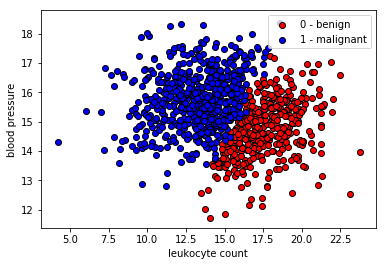

In [12]:
# Plot data
plot_tumors(df)